# Data Processing

This script defines the methods and classes for extracting data from the resulting fast5 files that are generated from running DeepSimulator. The user provides the path to DeepSimulator and to the genomic sequence of interest stored in .fasta format. DeepSimulator can generate simulated signals at various resolutions, including ground truth. All extracted data is converted to original float32 values, filtered, and placed into the hdf5 file format.


## Modules and Libraries
To filter, we use the filtration code we developed in filters.ipynb. To obtain, we use import_ipynb. h5py is a python interface allowing h5 file writing. Our database will be created in the h5 format. All other dependencies are from filters.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
from typing import Optional
import os
import time
from multiprocessing import Process, Queue
import h5py
import random

# Use filtration code developed in Filters.ipynb
import import_ipynb
from filters import Filters, TimesteppedFilters, ButterworthFilters

importing Jupyter notebook from filters.ipynb


## Electric Signal Reconstruction
.fast5 files store the raw electric current values in integer form to conserve space. This is done by using offset and scaling values which we can obtain and use to convert back to the original vales of raw electric current in pico-Amperes. This method handles this, given the path to the fast5 file and its name.

In [2]:
# Unpacks signals and restores to original values in pico-Amperes
def pA_convert(path_to_fast5, fname):
    os.system('h5ls -d %s/%s.fast5/Raw/Reads/Read_981/Signal >  %s/%s.data' % (path_to_fast5, 
                                                                               fname, 
                                                                               path_to_fast5, 
                                                                               fname))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/offset" %s/%s.fast5 > %s/shift.data' % (path_to_fast5,
                                                                                             fname, 
                                                                                             path_to_fast5))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/range" %s/%s.fast5 >> %s/shift.data' % (path_to_fast5,
                                                                                             fname, 
                                                                                             path_to_fast5))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/digitisation" %s/%s.fast5 >> %s/shift.data' % (path_to_fast5,
                                                                                                    fname, 
                                                                                                    path_to_fast5))
    raw = []

    with open('%s/%s.data' % (path_to_fast5, fname), 'r') as data:
        data.readline()
        data.readline()
        line = data.readline()
        while line != '':
            splitarr = line.split()
            splitarr.pop(0)
            last = splitarr[-1]
            for current in range(len(splitarr)):
                splitarr[current] = splitarr[current][:-1]
            raw.extend(splitarr)
            line = data.readline()
        raw[-1] = last
    
    # Get offset, range, and digitsation
    with open('%s/shift.data' % (path_to_fast5), 'r') as shift:
        for a in range(5):
            shift.readline()
        offsetLine = shift.readline()
        offsetArr = offsetLine.split()
        offsetArr.pop(0)
        offset = float(offsetArr[0])
    
        for b in range(8):
            shift.readline()
        rangeLine = shift.readline()
        rangeArr = rangeLine.split()
        rangeArr.pop(0)
        rang = float(rangeArr[0])
    
        for c in range(8):
            shift.readline()
        digLine = shift.readline()
        digArr = digLine.split()
        digArr.pop(0)
        dig = float(digArr[0])
    print('Offset:', offset, ', Range:', rang, ', Digitisation:', dig)

    os.system('rm %s/%s.data' % (path_to_fast5, fname))
    os.system('rm %s/shift.data' % (path_to_fast5))

    scale = rang/dig
    raw = np.array(raw, dtype=np.float32)

    signal = (raw + offset)*scale
    return signal

## Generating and Extracting Data
### Ground Truth Read
We need to generate a ground truth signal with no noise--essentially the results we would get if ONT's sequencing machines were ideal. The actual "perfect" option on DeepSimulator scales to the size of the sequence which is not ideal for comparison (due to some regions of data being "longer" once mapped to the correct size). Instead, the truth signal is generated manually by adding no Gaussian noise and using a frequency cutoff that is too high to affect results significantly. This is the signal we use to as the baseline to define a loss function against. 


### Noisy Read
To build a varied dataset, we want to generate signals with noise we can control. This signal's difference from the ground truth can be seen when we graph the first 500 measurements of both. The amount of Gaussian noise and the extent of cutting off higher frequencies can both be modified to the user's needs with the -e, -f, and -s parameters. Further information about DeepSimulator and its parameters can be found here: https://academic.oup.com/bioinformatics/article/36/8/2578/5698265#supplementary-data

In [3]:
# Object implementation so that reads can be generated several times with varying levels/types of noise
class genData:
    def __init__(self, path_to_deepsim, sequence, path_to_fasta):
        self.path_to_deepsim = path_to_deepsim
        self.sequence = sequence
        self.path_to_fasta = path_to_fasta
    
    # Generate truth read, convert back into pico-Amperes
    def truthRead(self, C=None):
        if C is not None:
            os.system('%s/deep_simulator.sh -i %s -C 1 -e 0 -f 12000 -s 0 -n -1' % (self.path_to_deepsim,
                                                                           self.path_to_fasta))
        else:   
            os.system('%s/deep_simulator.sh -i %s -e 0 -f 12000 -s 0 -n -1' % (self.path_to_deepsim,
                                                                           self.path_to_fasta))
        cwd = os.getcwd()
        PATH_TO_FAST5 = os.path.join(cwd, '%s_DeepSimu/fast5' % self.sequence)
        f = []
        for (dirpath, dirnames, filenames) in os.walk(PATH_TO_FAST5):
            f.extend(filenames)
            break
    
        truth = f[0][:-6]
        truthRead = pA_convert(PATH_TO_FAST5, truth)
        os.system('rm -r %s_DeepSimu' % self.sequence)
        return truthRead

    # Generate the noisy read to user's specification or use defaults, convert back to pico-Amperes
    def noisyRead(self, C=None, e=None, f=None, s=None):
        
        # Can only use custom noise if event_std (e), cutoff frequency (f), and signal_std (s) are all passed
        if (e is not None) and (f is not None) and (s is not None):
            if C is not None: 
                os.system('%s/deep_simulator.sh -i %s -C 1 -e %s -f %s -s %s -n -1' % (self.path_to_deepsim,
                                                                              self.path_to_fasta,e, f, s))
            else:                                                                  
                os.system('%s/deep_simulator.sh -i %s -e %s -f %s -s %s -n -1' % (self.path_to_deepsim,
                                                                              self.path_to_fasta,
                                                                              e, f, s))
        else:
            #defaults: event_std = 1.0, cutoff frequency = 950 Hz, signal_std = 1.0
            if C is not None:
                os.system('%s/deep_simulator.sh -i %s -C 1 -n -1' % (self.path_to_deepsim,
                                                            self.path_to_fasta))
            else:
                os.system('%s/deep_simulator.sh -i %s -n -1' % (self.path_to_deepsim,
                                                            self.path_to_fasta))
        
        cwd = os.getcwd()
        PATH_TO_FAST5 = os.path.join(cwd, '%s_DeepSimu/fast5' % self.sequence)
        f = []
        for (dirpath, dirnames, filenames) in os.walk(PATH_TO_FAST5):
            f.extend(filenames)
            break

        noisy = f[0][:-6]
        noisyRead = pA_convert(PATH_TO_FAST5, noisy)
        os.system('rm -r %s_DeepSimu' % self.sequence)
        return noisyRead

## Data Treatment

After obtaining truth and noisy reads for a sequence (Human Chromosome 22 in this case) we run them through the optParams method. optParams segments the truth and noisy data into groups of 100 raw nanopore signals, randomly selects the user-specified number of segments to work with, runs them through all the circuit filters and only the Bandworth Low Pass filter, optimizes parameters, and returns 3 outputs.
- 'subNoisy' is an array containing all the segments that the computer randomly chose to filter
- 'label' is a list of arrays of tuples. The tuple contains the filter type and optimal parameters. The array holds the tuple for each filter type. Each array corresponds with one segment from subNoisy
- 'errArr' is an array that holds all the mean squared errors of the segments filtered with each filter against the ground truth segment.

The optParams function also allows the user to visualize all of the filtration against ground truth if specified. However, the 'visualize' parameter is optional and all the 3 outputs can be generated without. This allows us to filter large quantities of data. 

In [4]:
# Dividing reads into segments to filter individually
class dataTreatment:
    def __init__(self, noisyRead, truthRead, nsamples):
        self.noisyRead = noisyRead
        self.truthRead = truthRead
        self.nsamples = nsamples
        
    def segmentData(self, read):
        cutLen = 100 #currently fixed length; will later be an array telling length of each k-mer
        ncuts = (int) (len(read)/cutLen)
    
        cutArr = np.empty(ncuts) #defines indices to 'cut' the raw data; to be refined later (cwDTW_nano)
        start = 0
        for idx in range(cutArr.size):
            cutArr[idx] = (int) (start+cutLen)
            start = start+cutLen
        dataList =[] #list used for when sequence length becomes variable later
        startidx = 0
        for subsignal in range(ncuts):
            endidx = int(cutArr[subsignal])
            dataList.append(read[startidx:endidx])
            startidx = endidx
        dataList.append(self.noisyRead[startidx:])
        return dataList
    
    """
    #used to parallelize calculations
    def queueFilters(obj, truth, ftype, q, order=None):
        if order is not None:
            q.put(obj.timestepped.optSolve(order, truth, ftype=ftype))
        else:
            q.put(obj.timestepped.optSolve(truth, ftype=ftype))
    """

    # Runs samples through filters to choose optimal filters and parameters
    def optParams(self, visualize=None): # 'visualize' defaults to False if not provided
        noisyList = self.segmentData(self.noisyRead)
        truthList = self.segmentData(self.truthRead)
        idxArr = np.empty(self.nsamples, dtype='int') #array of random indices
    
        # Only using nsamples of the original list, randomly sampled
        subNoisy = []
        subTruth = []
    
        # Assigning the same random samples to both subLists
        for n in range(self.nsamples):
            idxArr[n] = random.randint(0, len(noisyList))
            subNoisy.append(noisyList[idxArr[n]]) 
            subTruth.append(truthList[idxArr[n]])
    
        label = []
        errArr = np.empty([self.nsamples, 4])
    
        # Filtering each segment
        for sample in range(self.nsamples): 
            #startTime =  time.time()
            dspan = np.linspace(0, subNoisy[sample].size, subNoisy[sample].size)
            if visualize is True:
                plt.plot(dspan, subNoisy[sample], label='Noisy Signal')
                plt.plot(dspan, subTruth[sample],'--', label='Ground Truth')
                plt.legend(loc='upper right')
                plt.margins(0.05, 0.4)
                plt.xlabel('Nanopore Measurements')
                plt.ylabel('Ionic Current (pA)')  
                plt.title('Unfiltered Signal and Truth')
               # path = os.path.join(PATH_TO_FIGURES, 'noisysegmentread.png')
                plt.show()
                print('Unfiltered Err: ', np.linalg.norm(subNoisy[sample]-subTruth[sample])**2/subTruth[sample].size)
               # plt.savefig(path)
        
            # Frequency Domain representation of the noisy signal segment
            filterobj = Filters(dspan, subNoisy[sample])
            params = np.empty(3)
            params = filterobj.maxFreq(np.max(dspan))
            if visualize is True:
                print('Strongest frequency at:', params[3][0], 'Hz')
                #path = os.path.join(PATH_TO_FIGURES, 'noisysegementfreq.png')
                filterobj.graphFFT(params[0], params[1], params[2])
                #plt.savefig(path)

           
            """
            # Adding odd harmonics of largest signal to noisy data before filtering
            superPositioned = filterobj.superPosition(params[3][0])
            if visualize is True:
                print('Error with superpositioning', filterobj.relErr(superPositioned, subTruth[sample]))
                plt.plot(dspan, superPositioned, label='Filtered') #sqlowfilter[0].y[0,:]+
                plt.plot(dspan, subTruth[sample], '--',label='Truth')
                plt.legend(loc='upper right')
                plt.margins(0.05, 0.4)
                plt.title('Odd Harmonics Superimposed on (Bandworth Low Pass) Filtered Signal')
                plt.show()
            """
        
            timestepped = TimesteppedFilters(dspan, subNoisy[sample]) # superPositioned if superPosition func used
            butterworth = ButterworthFilters(dspan, subNoisy[sample])
            
            """
            #attempt to paralellize calculations
            qout = 0
            qout = Queue()
            processes = []
            p1 = Process(target=self.queueFilters, args=(timestepped, subTruth[sample], 'lowpass', qout))
            processes.append(p1)
            p1.start()
            p2 = Process(target=self.queueFilters, args=(timestepped, subTruth[sample], 'highpass', qout))
            processes.append(p2)
            p2.start()
            p3 = Process(target=self.queueFilters, args=(timestepped, subTruth[sample], 'bandpass', qout))
            processes.append(p3)
            p3.start()
            p4 = Process(target=self.queueFilters, args=(butterworth, subTruth[sample], 'lowpass', qout, 10))
            processes.append(p4) 
            p4.start()
            for p in processes:
                p.join()
            
            lowfilter = qout.get()[0]
            highfilter = qout.get()[1]
            bandpassfilter = qout.get()[2]
            butterlow = qout.get()[3]
            """
        
            lowfilter = timestepped.optSolve(subTruth[sample], ftype='lowpass')
            highfilter = timestepped.optSolve(subTruth[sample], ftype='highpass')
            bandpassfilter = timestepped.optSolve(subTruth[sample], ftype='bandpass')
            butterlow  = butterworth.optSolve(10, subTruth[sample], ftype='lowpass')
        
            """
            #other butterworth filters; currently unreliable
            butterhigh = butterworth.optSolve(10, subTruth[sample], ftype='highpass')
            butterbpass = butterworth.optSolve(10, subTruth[sample], ftype='bandpass')
            butterbstop = butterworth.optSolve(10, subTruth[sample], ftype='bandstop')
            """
            
            if visualize is True:
                #path = os.path.join(PATH_TO_FIGURES, 'segmentlowpass.png')
                timestepped.graph(lowfilter, 'Low Pass', truth=subTruth[sample])
                #plt.savefig(path)
                print('Low Pass Err: ', timestepped.relErr(lowfilter[0].y[0,:], subTruth[sample]))
                #path = os.path.join(PATH_TO_FIGURES, 'segmenthighpass.png')
                timestepped.graph(highfilter, 'High Pass', truth=subTruth[sample])
                #plt.savefig(path)
                print('High Pass Err: ', timestepped.relErr(highfilter[0].y[0,:], subTruth[sample]))
                #path = os.path.join(PATH_TO_FIGURES, 'segmentbandpass.png')
                timestepped.graph(bandpassfilter, 'Band Pass', truth=subTruth[sample])
                #plt.savefig(path)
                print('Band Pass Err: ', timestepped.relErr(bandpassfilter[0].y[0,:], subTruth[sample]))
                #path = os.path.join(PATH_TO_FIGURES, 'segmentbutterlowpass.png')
                butterworth.graph(butterlow[0], butterlow[1], 'Low Pass', truth=subTruth[sample])
                #plt.savefig(path)
                print('Butterworth Low Pass Err: ', timestepped.relErr(butterlow[0], subTruth[sample]))
           
            errArr[sample][0] = timestepped.relErr(lowfilter[0].y[0,:], subTruth[sample])
            errArr[sample][1] = timestepped.relErr(highfilter[0].y[0,:], subTruth[sample])
            errArr[sample][2] = timestepped.relErr(bandpassfilter[0].y[0,:], subTruth[sample])
            errArr[sample][3] = butterworth.relErr(butterlow[0], subTruth[sample])
            #errArr[4] = butterworth.relErr(butterhigh[0], subTruth[sample])
            #errArr[4] = butterworth.relErr(butterbpass[0], subTruth[sample])
            #errArr[5] = butterworth.relErr(butterbstop[0], subTruth[sample])
        
            label.append([['Lowpass', lowfilter[1]], 
                        ['Highpass', highfilter[1]], 
                        ['Bandpass', bandpassfilter[1]], 
                        ['Butterworth Lowpass', butterlow[1]]]) 
            #endTime =  time.time()
            #print('Elapsed time of a segment filtration (s)', (endTime-startTime))
        return subNoisy, label, errArr

## HDF5 File Writing

We use the HDF5 file format to store our data primarily due to its increased data loading capabilities compared to other dataset objects/formats as well as its ability to only load part of the data into memory/RAM. initH5() should effectively be considered a 'reset' button; it will overwrite all the databases that exist inside the h5 file. It should only be used once when the user begins to build the database or wants to clear all progress and start afresh. appendH5() then adds onto the data inside the NanoporeFiltered.h5 file. It should be used after optParams is used.

In [5]:
class writeH5:
    def __init__(self, path_to_h5, subNoisy, label, h5name):
        self.path_to_h5 = path_to_h5
        self.subNoisy = subNoisy
        self.label = label
        self.h5name = h5name
        
    def initH5(self):
        with h5py.File('%s/%s.h5' % (self.path_to_h5, self.h5name), 'w') as f:
            dS = f.create_dataset('NoisySignals', ((0, 100)), maxshape=((1e6, 100)), chunks=True)     
            d1 = f.create_dataset('LowPass',  ((0, 2)), maxshape=((1e6, 2)), chunks=True)
            d2 = f.create_dataset('HighPass', ((0, 2)), maxshape=((1e6, 2)), chunks=True)
            d3 = f.create_dataset('BandPass',  ((0, 4)), maxshape=((1e6, 4)), chunks=True)
            d4 = f.create_dataset('ButterworthLowPass',  ((0, 2)), maxshape=((1e6, 2)), chunks=True)
        
    def appendH5(self):
        with h5py.File('%s/%s.h5' % (self.path_to_h5, self.h5name), 'a') as f:
        
            # Appending to Signal Dataset
            dset = f['NoisySignals']
            length = len(dset)
            data = np.empty([len(self.subNoisy), 100])
            dset.resize((length+len(self.subNoisy), 100))
            for signal in range(len(self.subNoisy)):
                data[signal] = self.subNoisy[signal]
            dset[length:length+len(self.subNoisy)] = data
        
            # Appending LowPass parameters
            dset = f['LowPass']
            length = len(dset)
            data = np.empty([len(self.subNoisy), 2])
            dset.resize((length+len(self.subNoisy), 2))
            for lowparam in range(len(self.subNoisy)):
                data[lowparam][0] = self.label[lowparam][0][1][0]
                data[lowparam][1] = self.label[lowparam][0][1][1]
            dset[length:length+len(self.subNoisy)] = data
            dset[length:length+len(self.subNoisy)] = data
        
            # Appending HighPass parameters
            dset = f['HighPass']
            length = len(dset)
            data = np.empty([len(self.subNoisy), 2])
            dset.resize((length+len(self.subNoisy), 2))
            for highparam in range(len(self.subNoisy)):
                data[highparam][0] = self.label[highparam][1][1][0]
                data[highparam][1] = self.label[highparam][1][1][1]
            dset[length:length+len(self.subNoisy)] = data
            dset[length:length+len(self.subNoisy)] = data
        
            # Appending BandPass parameters
            dset = f['BandPass']
            length = len(dset)
            data = np.empty([len(self.subNoisy), 4])
            dset.resize((length+len(self.subNoisy), 4))
            for bandparam in range(len(self.subNoisy)):
                data[bandparam][0] = self.label[bandparam][2][1][0]
                data[bandparam][1] = self.label[bandparam][2][1][1]
                data[bandparam][2] = self.label[bandparam][2][1][2]
                data[bandparam][3] = self.label[bandparam][2][1][3]
            dset[length:length+len(self.subNoisy)] = data
            dset[length:length+len(self.subNoisy)] = data
        
            # Appending ButterworthLowPass parameters
            dset = f['ButterworthLowPass']
            length = len(dset)
            data = np.empty([len(self.subNoisy), 2])
            dset.resize((length+len(self.subNoisy), 2))
            for butterlparam in range(len(self.subNoisy)):
                data[butterlparam][0] = self.label[butterlparam][3][1][0]
                data[butterlparam][1] = self.label[butterlparam][3][1][1]
            dset[length:length+len(self.subNoisy)] = data
            dset[length:length+len(self.subNoisy)] = data

# User Interface

The code below demonstrates what the user provides to generate the labels metadata and the segmented data. This allows users to easily generate data at various resolutions. 

## Example Implementation on Human Chromosome 22
The object-oriented approach to generating data lets us generate a truth signal only once, then build with a variety of noise to append to a database. The user only needs to provide the path to DeepSimulator and the sequence name of the .fasta file used. Note that when custom noise is used, **all** of the optional parameters must be provided. 

In [6]:
# Creating ground truth read and noisy read for 1M base-pairs on Human Chromosome 22
if __name__ == '__main__':
    PATH_TO_DEEPSIM = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/DeepSimulator'
    SEQUENCE = 'artificial_human_chr22'
    PATH_TO_FASTA = os.path.join(PATH_TO_DEEPSIM, 'example/%s.fasta' % SEQUENCE)
    # User is recommended to place .fasta files in subdirectory of DeepSimulator; eg. 'example'

    humanChr22 = genData(PATH_TO_DEEPSIM, SEQUENCE, PATH_TO_FASTA)
    truthRead = humanChr22.truthRead()
    noisyRead = humanChr22.noisyRead()

Offset: 37.0 , Range: 1368.36 , Digitisation: 8192.0
Offset: 37.0 , Range: 1368.36 , Digitisation: 8192.0


## Visualizing Data
The cell below is purely for visualization purposes; the user doesn't need to write any of the following. These plots help explain why mapping a "perfect" signal with a smaller size is difficult. It is easily apparent that some plateaus are brief in occurance while other areas' plateaus have longer periods.
In the future, we may use Dynamic Time Warping tools like cwDTW_nano to perform such mapping to reduce some error, but for now, keeping a high cutoff frequency is sufficient. 

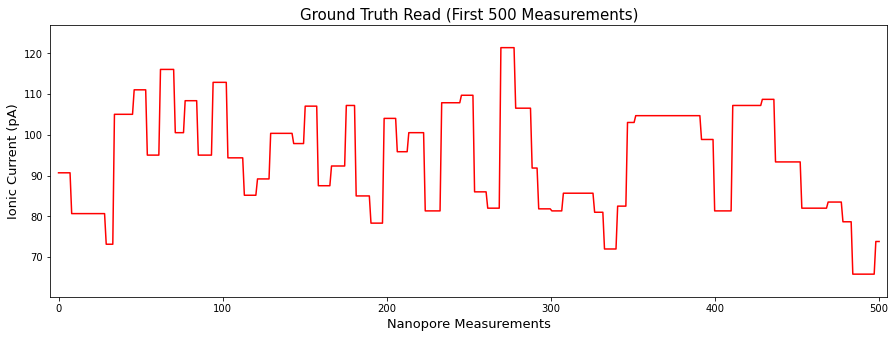

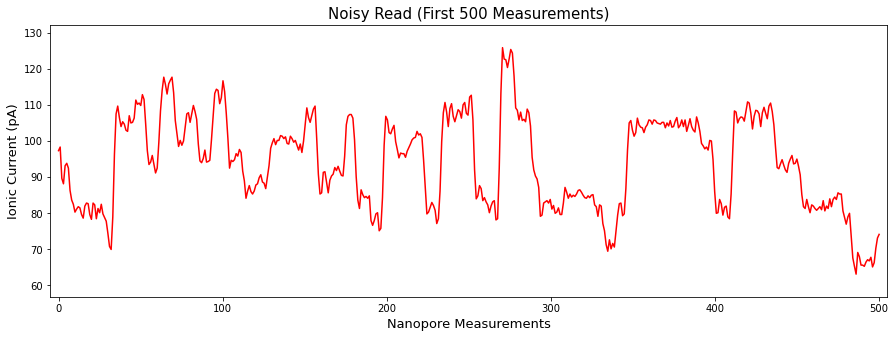

In [7]:
# Graphing ground truth read and noisy tread
PATH_TO_FIGURES = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/figures'
if __name__ == '__main__': 
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, 500, 500), truthRead[:500], color='red')
    plt.title('Ground Truth Read (First 500 Measurements)', fontsize='15')
    plt.xlabel('Nanopore Measurements', fontsize='13')
    plt.ylabel('Ionic Current (pA)', fontsize='13')
   # path = os.path.join(PATH_TO_FIGURES, 'groundtruthread.png')
    plt.margins(0.01, 0.1)
    plt.show()
    #plt.savefig(path)

    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, 500, 500), noisyRead[0:500], color='red')
    plt.title('Noisy Read (First 500 Measurements)', fontsize='15')
    plt.xlabel('Nanopore Measurements', fontsize='13')
    plt.ylabel('Ionic Current (pA)', fontsize='13')
    plt.margins(0.01, 0.1) 
    #path = os.path.join(PATH_TO_FIGURES, 'noisyread.png')
    plt.show()
    #plt.savefig(path)

## Filtering Segments

The actual filtering takes place largely "under the hood" so very little user input is required after generating truth and noisy reads. The visualize option allows users to see exactly what filtering is happening, how effective it is, and whether super positioning may be necessary.

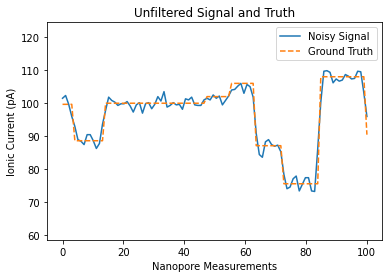

Unfiltered Err:  5.143839711559849
Strongest frequency at: 0.03 Hz


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


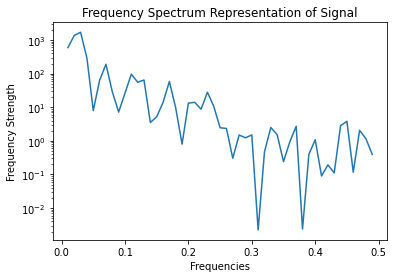

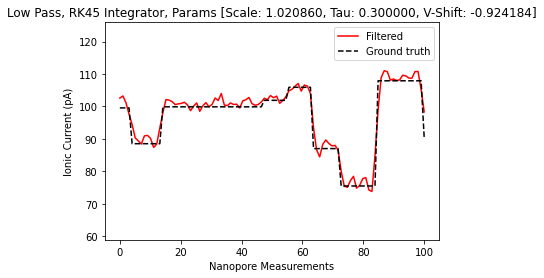

Low Pass Err:  5.953808152560681


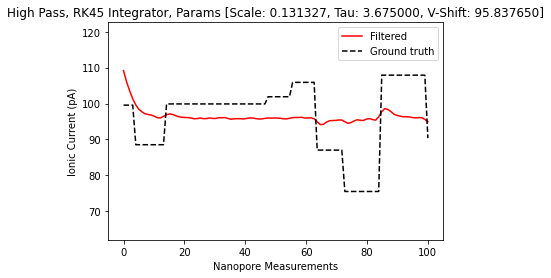

High Pass Err:  96.65550562587747


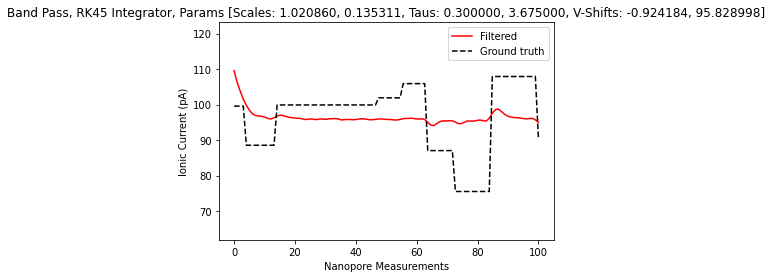

Band Pass Err:  96.42053081515638


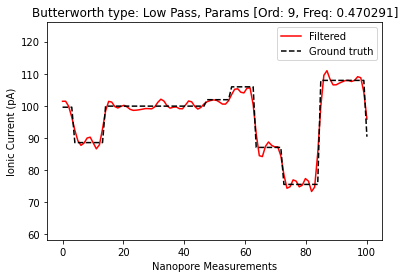

Butterworth Low Pass Err:  4.281001231580559
[[['Lowpass', array([ 1.02085973,  0.3       , -0.92418426])], ['Highpass', array([ 0.13132726,  3.675     , 95.83764983])], ['Bandpass', array([ 1.02085973,  0.3       , -0.92418426,  0.13531054,  3.675     ,
       95.82899847])], ['Butterworth Lowpass', array([9.        , 0.47029111])]]] [[ 5.95380815 96.65550563 96.42053082  4.28100123]]


In [8]:
if __name__ == '__main__':
    treated = dataTreatment(noisyRead, truthRead, 1)
    noisyData, labels, errors = treated.optParams(visualize=True)
    print(labels, errors)

In [9]:
if __name__ == '__main__':
    PATH_TO_H5 = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/database'
    H5NAME = 'test'
    testobj = writeH5(PATH_TO_H5, noisyData, labels, H5NAME)
    testobj.initH5()
    testobj.appendH5()